In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from gw_distance_matrix import *
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from jax import numpy as jnp
rng = np.random.default_rng(seed=0)

root_path = Path("../..")
data_path = root_path / "data"

In [5]:
points, properties = pickle.load(open(data_path / "halos.pkl", 'rb'))
points_list = [p["Coordinates"] for p in points]

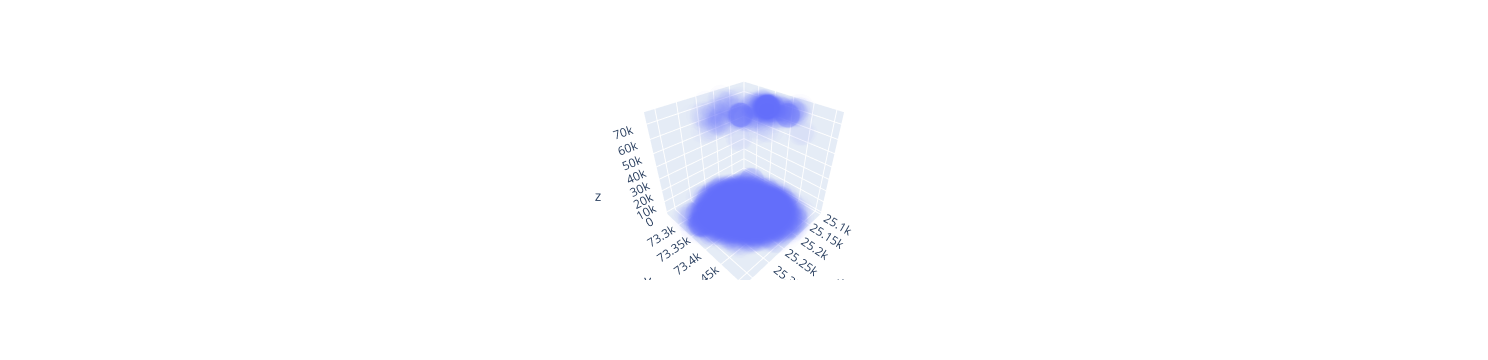

In [6]:
points_a = points[0]["Coordinates"]
# indices = points_a[:, 2] > 10_000
indices = np.arange(points_a.shape[0])
# plt.scatter(points_a[indices, 0], points_a[indices, 2], s=1)
px.scatter_3d(x=points_a[indices, 0], y=points_a[indices, 1], z=points_a[indices, 2], opacity=0.01)

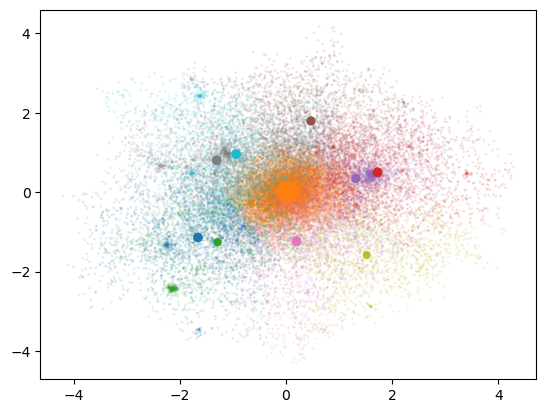

In [7]:
subsample = 10
i = 20

points_rec = points[i]["Coordinates"] - points[i]["Coordinates"].mean(axis=0, keepdims=True)
points_norm = points_rec / 30
weights, pointcloud, labels = kmeans_subsample(points_norm, subsample, random_state=1, include_labels=True)
raw_points = points[i]["Coordinates"]
raw_points -= raw_points.mean(axis=0, keepdims=True)
raw_points /= 30


plt.scatter(raw_points[:, 0], raw_points[:, 2], s=1, alpha=0.1, c=labels, cmap="tab10")
plt.scatter(pointcloud.x[:,0 ], pointcloud.x[:, 2], alpha=1, s=weights * 500, c=np.arange(subsample), cmap="tab10")

In [6]:
kmeans_solns = do_experiment(points_list[4], points_list[6], num_trials=20, subsample=100, subsample_method="kmeans", method="gw")
uniform_solns = do_experiment(points_list[4], points_list[6], num_trials=20, subsample=100, subsample_method="uniform", method="gw")

[Text(0.5, 1.0, 'Distribution of GW distances using different resampling methods\nNumber of samples: 100'),
 Text(0.5, 0, 'GW distance')]

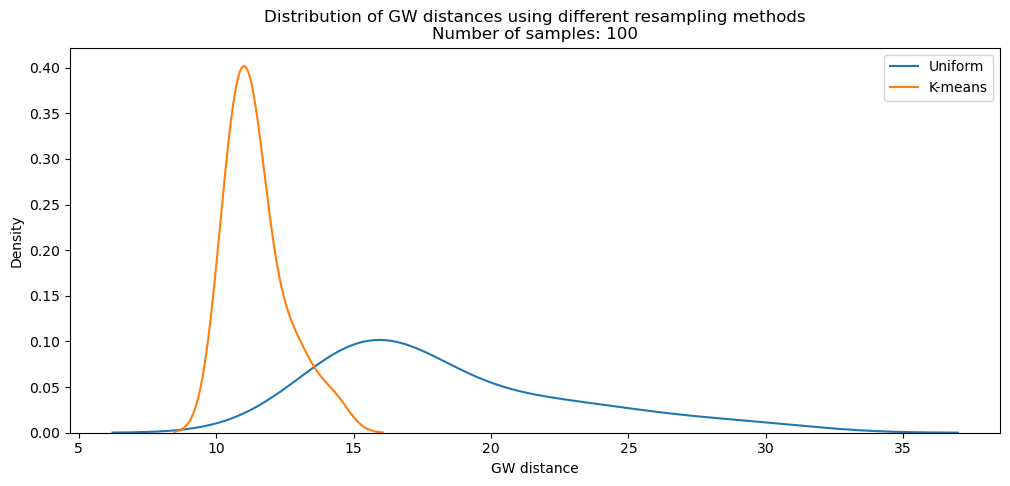

In [7]:
fig, ax = plt.subplots(figsize=(12, 5))
uniform_costs = [soln.costs[soln.costs != -1][-1].item() for soln in uniform_solns]
kmeans_costs = [soln.costs[soln.costs != -1][-1].item() for soln in kmeans_solns]
sns.kdeplot(uniform_costs, label="Uniform", ax=ax)
sns.kdeplot(kmeans_costs, label="K-means", ax=ax)
ax.legend()
ax.set(title=f"Distribution of GW distances using different resampling methods\nNumber of samples: {100}", xlabel="GW distance")

In [94]:
def get_distance_stats(num_trials, method="gw", use_k_means=False):
    solns = []
    for t in range(num_trials):
        rng = np.random.default_rng(seed=t)
        if use_k_means:
            kmeans = KMeans(n_clusters=subsample, random_state=t)
            kmeans.fit(points_a)
            pointcloud_a = pointcloud.PointCloud(kmeans.cluster_centers_)
            kmeans.fit(points_b)
            pointcloud_b = pointcloud.PointCloud(kmeans.cluster_centers_)

        else:
            indices_a = rng.choice(points_a.shape[0], subsample, replace=False)
            indices_b = rng.choice(points_b.shape[0], subsample, replace=False)

            pointcloud_a = pointcloud.PointCloud(points_a[indices_a])
            pointcloud_b = pointcloud.PointCloud(points_b[indices_b])

        prob = quadratic_problem.QuadraticProblem(pointcloud_a, pointcloud_b)
        match method:
            case "gw":
                solver = gromov_wasserstein.GromovWasserstein(epsilon=0.4)
            case "lb":
                solver = lower_bound.LowerBoundSolver(epsilon=0.5)
            case _:
                raise ValueError(f"Unknown method {method}")

        solns.append(solver(prob, max_iterations=10000))
    return solns

lb_trials = get_distance_stats(1, method="lb", use_k_means=True)
gw_trials = get_distance_stats(1, method="gw", use_k_means=True)

/home/daniel/mambaforge-pypy3/envs/pyot/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



KeyboardInterrupt: 

In [14]:
# plt.scatter([s.primal_cost.item() for s in lb_trials], [s.primal_cost.item() for s in gw_trials])
lb_trials[]

[SinkhornOutput(f=Array([-1.17285431e+02, -2.18293495e+01,  1.85374863e+02,  5.89875183e+01,
        -6.68893204e+01, -8.77484970e+01,  8.78498001e+01,  9.55896301e+02,
         2.11262436e+02, -9.64561386e+01, -5.51405449e+01, -1.08615051e+02,
         4.82830353e+02, -1.09713234e+02, -1.14571632e+02,  3.06281433e+02,
        -1.05379395e+02, -5.72301865e-01,  2.15591354e+02, -1.23518463e+02,
        -1.01210426e+02, -1.88247643e+01,  3.65144714e+02,  3.92964508e+02,
         2.15670578e+02,  1.38358459e+02, -1.09057091e+02, -8.55380154e+00,
        -3.15237331e+01,  4.95328918e+02,  5.58188965e+02, -1.05103241e+02,
         2.68562164e+01, -1.08692627e+02, -9.26733017e+01,  5.09848633e+01,
        -9.69850464e+01, -2.76041775e+01, -1.22686638e+02,  3.42061646e+02,
         1.54251007e+02,  2.19813175e+01,  4.40644806e+02, -6.08907471e+01,
        -1.35790344e+02,  4.56161041e+01, -8.27154617e+01, -3.79423065e+01,
         3.85536728e+01, -3.93822556e+01,  5.91226990e+02, -2.76842957e

In [9]:
# for soln in lb_trials:
#     plt.plot(soln.costs[soln.costs != -1])
plt.hist([soln.primal_cost.item() for soln in lb_trials])

(array([2., 0., 3., 2., 3., 5., 1., 3., 0., 1.]),
 array([14.50958061, 22.87479839, 31.24001617, 39.60523396, 47.97045174,
        56.33566952, 64.7008873 , 73.06610508, 81.43132286, 89.79654064,
        98.16175842]),
 <BarContainer object of 10 artists>)

(array([1., 3., 2., 3., 4., 3., 2., 1., 0., 1.]),
 array([ 39.5184021 ,  48.33645554,  57.15450897,  65.97256241,
         74.79061584,  83.60866928,  92.42672272, 101.24477615,
        110.06282959, 118.88088303, 127.69893646]),
 <BarContainer object of 10 artists>)

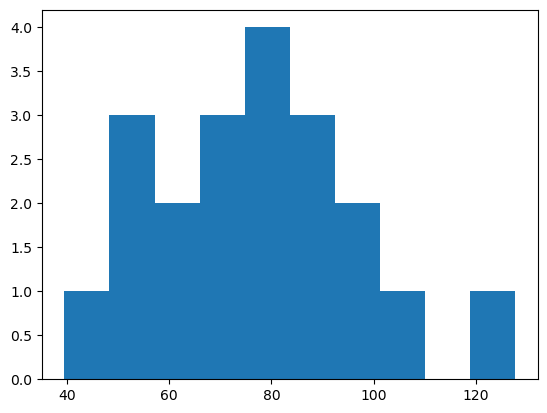

In [10]:
# for soln in gw_trials:
#     plt.plot(soln.costs[soln.costs != -1])
plt.hist([soln.primal_cost.item() for soln in gw_trials])

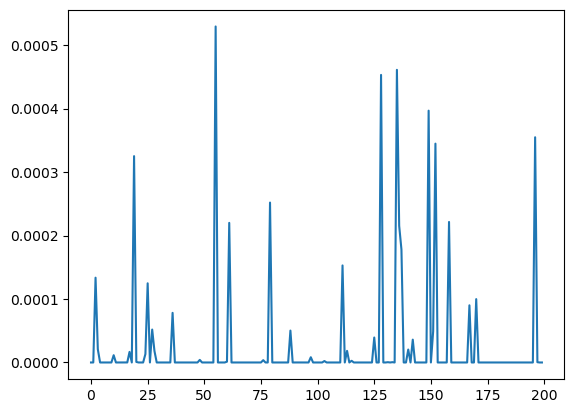

In [170]:
plt.plot(lb_trials[0].matrix[1])

Converged: True


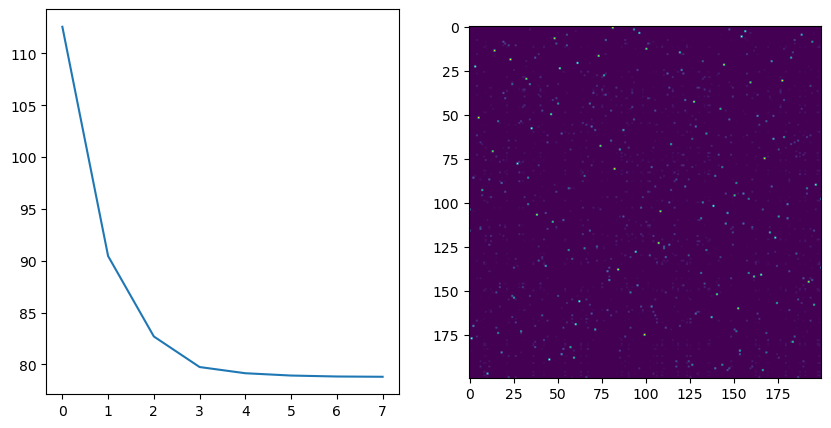

In [148]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(soln.costs[soln.costs != -1])
axs[1].imshow(soln.matrix)
print(f"Converged: {soln.converged}")

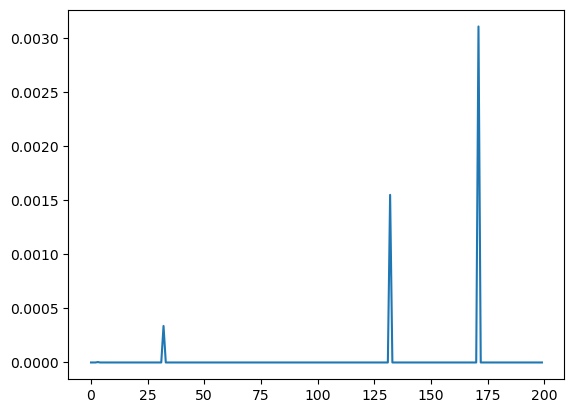

In [152]:
plt.plot(soln.matrix[20])